# Process ERA5 to ACCESS-ESM1-5 grid and time period

This will be used to verify and bias-correct the ACCESS model.

In [114]:
# from dask.distributed import Client,LocalCluster
# from dask_jobqueue import PBSCluster

In [115]:
# # One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

# walltime = '00:30:00'
# cores = 24
# memory = str(4 * cores) + 'GB'

# cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
#                      job_extra_directives=['-q normal',
#                                            '-P w42',
#                                            '-l ncpus='+str(cores),
#                                            '-l mem='+str(memory),
#                                            '-l storage=gdata/w42+gdata/rt52+gdata/fs38'],
#                      local_directory='$TMPDIR',
#                      job_directives_skip=["select"])
#                      # python=os.environ["DASK_PYTHON"])

In [116]:
# cluster.scale(jobs=1)
# client = Client(cluster)

In [117]:
# client#.restart()

In [21]:
import xarray as xr
import xesmf as xe
import dask

import matplotlib.pyplot as plt

In [2]:
%cd /g/data/w42/dr6273/work/LE_bias_correct/

import functions as fn

/g/data/w42/dr6273/work/LE_bias_correct


### Define models and variables

In [53]:
models = [
    "ACCESS-ESM1-5"
]

In [51]:
# List of lists. Each element has ERA5 name and new CMIP name
variables = [
    # ["2t", "tas"],
    ["mtpr", "pr"],
    ["2tmax", "tasmax"],
    ["msdwswrf", "rsds"],
    ["10w", "sfcWind"],
    ["100w", "w100"]
]

In [6]:
model_times = slice("1950", "2014")

### Model template grid

In [3]:
def get_template(model):
    """
    Return a time slice of the model grid.
    """
    model_path = fn.get_model_path(model)
    model_grid = fn.get_model_grid(model)
    filename = "tas_day_" + model + "_historical_r1i1p1f1_" + model_grid + "_20000101-20141231.nc"
    
    template = xr.open_mfdataset(
        model_path + "/r1i1p1f1/day/tas/" + model_grid + "/latest/" + filename
    )
    template = template["tas"].isel(time=0)
    template = fn.sel_Aus(template).drop(["time", "height"])
    return template.compute()

### ERA5 data.

Already have some variables daily.

In [57]:
def preprocess(ds):
    """
    Rename lat/lon and select Aus region
    """
    def _sel_Aus(ds, lat_name="lat", lon_name="lon"):
        """
        Select Australian region. For datasets with descending latitudes.
        """
        return ds.sel({lon_name: slice(110, 155), lat_name: slice(-8, -45)})
    ds = ds.rename({"longitude": "lon", "latitude": "lat"})
    return _sel_Aus(ds)

In [58]:
def rename_var(ds, new_name):
    """
    Rename var. For converting from ERA5 names to CMIP conventions
    """
    old_name = list(ds.data_vars)[0]
    return ds.rename({old_name: new_name})

In [59]:
def regrid(variable, new_name, out_ds, time_slice):
    """
    Open ERA5 data and regrid
    """
    path = "/g/data/w42/dr6273/work/data/era5/" + variable + "/daily/"
    
    ds = xr.open_mfdataset(path + "*.nc", preprocess=preprocess)
    ds = ds.sel(time=time_slice)
    regridder = xe.Regridder(ds, out_ds, "bilinear")
    new_ds = regridder(ds, keep_attrs=True)

    return rename_var(new_ds, new_name)

In [60]:
def write(ds, model, variable, region):
    """
    Write regridded CMIP data to netcdf.
    
    ds: dataset to write
    model: str, model name.
    variable: str, variable name
    region: str, name of region
    """
    filename = variable + "_era5_" + model + "_1959-2014_" + region + ".nc"
    ds.to_netcdf(
        "/g/data/w42/dr6273/work/data/era5/regridded/CMIP6/" + filename
    )

In [63]:
def regrid_write(model, template, variable, new_name, region, time_slice):
    """
    Open, regrid and write
    """
    # template = get_template(model)
    regridded = regrid(variable, new_name, template, time_slice)
    write(regridded, model, new_name, region)

### tas / 2t

In [41]:
t = regrid("2t", "tas", access_template, model_times)

/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/xarray/core/dataarray.py:857: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


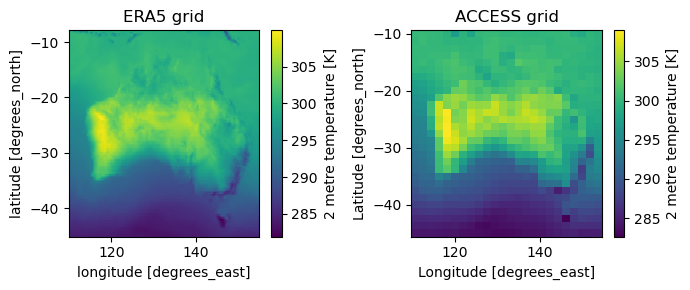

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

xr.open_mfdataset("/g/data/w42/dr6273/work/data/era5/2t/daily/*.nc", preprocess=preprocess)["t2m"].isel(time=0).plot(ax=ax[0])
ax[0].set_title("ERA5 grid")

t["tas"].isel(time=0).plot(ax=ax[1])
ax[1].set_title("ACCESS grid")

plt.tight_layout()

In [47]:
t.nbytes / 1024 ** 3

0.05318596214056015

In [ ]:
# regrid_write("ACCESS-ESM1-5", "2t", "tas", "AUS", model_times)

In [ ]:
for model in models:
    template = get_template(model)
    
    for var in variables:
        era_var = var[0]
        new_var = var[1]
        
        print(era_var, new_var)
        
        regrid_write(model, template, era_var, new_var, "AUS", model_times)

2t tas


/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/xarray/core/dataarray.py:857: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


mtpr pr


/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/xarray/core/dataarray.py:857: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


2tmax tasmax


/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/xarray/core/dataarray.py:857: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


msdwswrf rsds


/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/xarray/core/dataarray.py:857: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
